In [1]:
import os
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model,load_model
from collections import defaultdict

from utils.util import *
from utils.preprocessing import *
from utils.dataiter import Dataiter
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from utils.target_encode import MTE_one_shot

import tensorflow.keras.backend as K
import core.config as conf

## Load Data

In [2]:
path = f'{conf.dataset_mini_path}/train'
train = read_data(path)

path = f'{conf.dataset_mini_path}/test'
test = read_data(path)

path = f'{conf.dataset_mini_path}/valid'
valid = read_data(path)

KeyboardInterrupt: 

In [ ]:
TARGET = ['like', 'reply', 'retweet', 'comment']

## Preprocessing

In [ ]:
def set_dataframe_types(df, train):
    df['id']   = np.arange( df.shape[0] )
    df['id']   = df['id'].astype(np.uint32)

    if train:
        df['reply_timestamp']   = df['reply_timestamp'].fillna(0)
        df['retweet_timestamp'] = df['retweet_timestamp'].fillna(0)
        df['comment_timestamp'] = df['comment_timestamp'].fillna(0)
        df['like_timestamp']    = df['like_timestamp'].fillna(0)

        df['reply_timestamp']   = df['reply_timestamp'].astype(np.uint32)
        df['retweet_timestamp'] = df['retweet_timestamp'].astype(np.uint32)
        df['comment_timestamp'] = df['comment_timestamp'].astype(np.uint32)
        df['like_timestamp']    = df['like_timestamp'].astype(np.uint32)

    df['tweet_timestamp']         = df['tweet_timestamp'].astype( np.uint32 )
    df['creator_follower_count']  = df['creator_follower_count'].astype( np.uint32 )
    df['creator_following_count'] = df['creator_following_count'].astype( np.uint32 )
    df['creator_account_creation']= df['creator_account_creation'].astype( np.uint32 )
    df['engager_follower_count']  = df['engager_follower_count'].astype( np.uint32 )
    df['engager_following_count'] = df['engager_following_count'].astype( np.uint32 )
    df['engager_account_creation']= df['engager_account_creation'].astype( np.uint32 )

    return df



def preprocess(df, target, train):
    df = set_dataframe_types(df, train)
    # df = df.set_index('id')
    # df.columns = conf.raw_features + conf.labels
    df = df.drop('text_tokens', axis=1)
    
    df = feature_extraction(df, features=conf.used_features, train=train) # extract 'used_features'
    cols = []

    return df

In [ ]:
train = preprocess(train, TARGET, True)
valid = preprocess(valid, TARGET, True)
test = preprocess(test, TARGET, True)

In [ ]:
train

### pickle matching

#### language

In [ ]:
pickle_path = conf.dict_path

In [ ]:
user_main_language_path = pickle_path + "user_main_language.pkl"

if os.path.exists(user_main_language_path) :
    with open(user_main_language_path, 'rb') as f :
        user_main_language = pickle.load(f)

In [ ]:
language_dict_path = pickle_path + "language_dict.pkl"

if os.path.exists(language_dict_path ) :
    with open(language_dict_path , 'rb') as f :
        language_dict = pickle.load(f)

In [ ]:
train['language'] = train.apply(lambda x : language_dict[x['language']], axis = 1)
test['language'] = test.apply(lambda x : language_dict[x['language']], axis = 1)
valid['language'] = valid.apply(lambda x : language_dict[x['language']], axis = 1)

In [ ]:
del language_dict

In [ ]:
train['creator_main_language'] = train['creator_id'].map(user_main_language)
valid['creator_main_language'] = valid['creator_id'].map(user_main_language)
test['creator_main_language'] = test['creator_id'].map(user_main_language)

In [ ]:
train['engager_main_language'] = train['engager_id'].map(user_main_language)
valid['engager_main_language'] = valid['engager_id'].map(user_main_language)
test['engager_main_language'] = test['engager_id'].map(user_main_language)

In [ ]:
train['creator_and_engager_have_same_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
valid['creator_and_engager_have_same_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
test['creator_and_engager_have_same_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)

In [ ]:
train['is_tweet_in_creator_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_creator_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_creator_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)

In [ ]:
train['is_tweet_in_engager_main_language'] = train.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_engager_main_language'] = valid.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_engager_main_language'] = test.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)

In [ ]:
del user_main_language

In [ ]:
train.head()

#### engagements

In [ ]:
engagement_like_path = pickle_path + "engagement-like.pkl"

if os.path.exists(engagement_like_path ) :
    with open(engagement_like_path , 'rb') as f :
        engagement_like = pickle.load(f)

In [ ]:
train['engager_feature_number_of_previous_like_engagement'] = train.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_like_engagement'] = valid.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_like_engagement'] = test.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
del engagement_like

In [ ]:
engagement_reply_path = pickle_path + "engagement-reply.pkl"

if os.path.exists(engagement_reply_path ) :
    with open(engagement_reply_path , 'rb') as f :
        engagement_reply = pickle.load(f)

In [ ]:
train['engager_feature_number_of_previous_reply_engagement'] = train.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_reply_engagement'] = valid.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_reply_engagement'] = test.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
del engagement_reply

In [ ]:
engagement_retweet_path = pickle_path + "engagement-retweet.pkl"

if os.path.exists(engagement_retweet_path ) :
    with open(engagement_retweet_path , 'rb') as f :
        engagement_retweet = pickle.load(f)

In [ ]:
train['engager_feature_number_of_previous_retweet_engagement'] = train.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_retweet_engagement'] = valid.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_retweet_engagement'] = test.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
del engagement_retweet

In [ ]:
engagement_comment_path = pickle_path + "engagement-comment.pkl"

if os.path.exists(engagement_comment_path ) :
    with open(engagement_comment_path , 'rb') as f :
        engagement_comment = pickle.load(f)

In [ ]:
train['engager_feature_number_of_previous_comment_engagement'] = train.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_comment_engagement'] = valid.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_comment_engagement'] = test.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
del engagement_comment

In [ ]:
train['number_of_engagements_positive'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
valid['number_of_engagements_positive'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
test['number_of_engagements_positive'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)

### Tweet Engagements

In [ ]:
tweet_engagement_path = pickle_path + "tweet_id_engagement_1.pkl"

if os.path.exists(tweet_engagement_path ) :
    with open(tweet_engagement_path, 'rb') as f :
        tweet_engagements = pickle.load(f)
        tweet_engagements = defaultdict(lambda : -1, tweet_engagements)

In [ ]:
train['number_of_tweet_engagements'] = train.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
valid['number_of_tweet_engagements'] = valid.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
test['number_of_tweet_engagements'] = test.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)

del tweet_engagements

In [ ]:
train1 = train[train['number_of_tweet_engagements'] != -1]
train = train[train['number_of_tweet_engagements'] == -1]

valid1 = valid[valid['number_of_tweet_engagements'] != -1]
valid = valid[valid['number_of_tweet_engagements'] == -1]

test1 = test[test['number_of_tweet_engagements'] != -1]
test = test[test['number_of_tweet_engagements'] == -1]

In [ ]:
tweet_engagement_path = pickle_path + "tweet_id_engagement_2.pkl"

if os.path.exists(tweet_engagement_path ) :
    with open(tweet_engagement_path, 'rb') as f :
        tweet_engagements = pickle.load(f)
        tweet_engagements = defaultdict(lambda : -1, tweet_engagements)

In [ ]:
train['number_of_tweet_engagements'] = train.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
valid['number_of_tweet_engagements'] = valid.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
test['number_of_tweet_engagements'] = test.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)

del tweet_engagements

In [ ]:
train2 = train[train['number_of_tweet_engagements'] != -1]
train = train[train['number_of_tweet_engagements'] == -1]

valid2 = valid[valid['number_of_tweet_engagements'] != -1]
valid = valid[valid['number_of_tweet_engagements'] == -1]

test2 = test[test['number_of_tweet_engagements'] != -1]
test = test[test['number_of_tweet_engagements'] == -1]

In [ ]:
tweet_engagement_path = pickle_path + "tweet_id_engagement_3.pkl"

if os.path.exists(tweet_engagement_path ) :
    with open(tweet_engagement_path, 'rb') as f :
        tweet_engagements = pickle.load(f)
        tweet_engagements = defaultdict(lambda : -1, tweet_engagements)

In [ ]:
train['number_of_tweet_engagements'] = train.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
valid['number_of_tweet_engagements'] = valid.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)
test['number_of_tweet_engagements'] = test.apply(lambda x : tweet_engagements[x['tweet_id']], axis = 1)

del tweet_engagements

In [ ]:
train = pd.concat([train1, train2, train])
valid = pd.concat([valid1, valid2, valid])
test = pd.concat([test1, test2, test])

In [ ]:
train

In [ ]:
del train1, train2, valid1, valid2, test1, test2

In [ ]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
train['number_of_engagements_ratio_like'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_like'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_like'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [ ]:
train['number_of_engagements_ratio_reply'] = train.apply(lambda x : x['engager_feature_number_of_previous_reply_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_reply'] = valid.apply(lambda x : x['engager_feature_number_of_previous_reply_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_reply'] = test.apply(lambda x : x['engager_feature_number_of_previous_reply_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [ ]:
train['number_of_engagements_ratio_retweet'] = train.apply(lambda x : x['engager_feature_number_of_previous_retweet_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_retweet'] = valid.apply(lambda x : x['engager_feature_number_of_previous_retweet_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_retweet'] = test.apply(lambda x : x['engager_feature_number_of_previous_retweet_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [ ]:
train['number_of_engagements_ratio_comment'] = train.apply(lambda x : x['engager_feature_number_of_previous_comment_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_comment'] = valid.apply(lambda x : x['engager_feature_number_of_previous_comment_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_comment'] = test.apply(lambda x : x['engager_feature_number_of_previous_comment_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

## Split

In [ ]:
label_names = ['reply', 'retweet', 'comment', 'like']
DONT_USE = ['tweet_timestamp','creator_account_creation','engager_account_creation','engage_time',
            'creator_account_creation', 'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'engager_id','creator_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language','language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels

In [ ]:
RMV = [c for c in DONT_USE if c in train.columns]

In [48]:
yt_train = train[TARGET]
Xt_train = train.drop(RMV, axis=1)

In [49]:
yt_valid = valid[TARGET]
Xt_valid = valid.drop(RMV, axis=1)
del valid

In [50]:
yt_test = test[TARGET]
Xt_test = test.drop(RMV, axis=1)
del test

## Scaling

In [51]:
Xt_train = Xt_train.reset_index(drop=True)
Xt_test = Xt_test.reset_index(drop=True)
Xt_val = Xt_valid.reset_index(drop=True)

In [52]:
scaling_columns = ['creator_following_count', 'creator_follower_count', 'engager_follower_count', 
                   'engager_following_count', 'dt_dow', 'dt_hour', 'len_domains', 'creator_main_language', 'engager_main_language',
                   'engager_feature_number_of_previous_like_engagement',
                   'engager_feature_number_of_previous_reply_engagement',
                   'engager_feature_number_of_previous_retweet_engagement',
                   'engager_feature_number_of_previous_comment_engagement',
                   'number_of_engagements_positive',
                   'number_of_tweet_engagements']

In [53]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(Xt_train[scaling_columns])

StandardScaler()

In [54]:
ss = standard_scaler.transform(Xt_train[scaling_columns])
Xt_train[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [55]:
ss = standard_scaler.transform(Xt_valid[scaling_columns])
Xt_valid[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [56]:
ss = standard_scaler.transform(Xt_test[scaling_columns])
Xt_test[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [57]:
Xt_train = Xt_train.fillna(Xt_train.mean())
Xt_valid = Xt_valid.fillna(Xt_valid.mean())
Xt_test = Xt_test.fillna(Xt_test.mean())

## Modeling

In [58]:
# target_to_idx = {'reply':0, 'retweet':1, 'comment':2, 'like':3, 'all' : 4}

In [59]:
target = 'comment'
idx = conf.target_to_idx[target]

In [60]:
X_train = Xt_train.drop(conf.drop_features[idx], axis = 1)
y_train = yt_train[target]

In [61]:
X_test = Xt_test.drop(conf.drop_features[idx], axis = 1)
y_test = yt_test[target]

In [62]:
X_valid = Xt_valid.drop(conf.drop_features[idx], axis = 1)
y_valid = yt_valid[target]

In [63]:
model = Sequential([
    Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [64]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy']) # sigmoid :binary_crossentropy

In [65]:
result = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_valid, y_valid),
    epochs=3,
    batch_size=32
)

Epoch 1/3
135591/135591 [==============================] - 62s 454us/step - loss: 0.0324 - binary_crossentropy: 0.0324 - val_loss: 0.0312 - val_binary_crossentropy: 0.0312
Epoch 2/3
135591/135591 [==============================] - 62s 456us/step - loss: 0.0315 - binary_crossentropy: 0.0315 - val_loss: 0.0311 - val_binary_crossentropy: 0.0311
Epoch 3/3
135591/135591 [==============================] - 62s 456us/step - loss: 0.0314 - binary_crossentropy: 0.0314 - val_loss: 0.0311 - val_binary_crossentropy: 0.0311


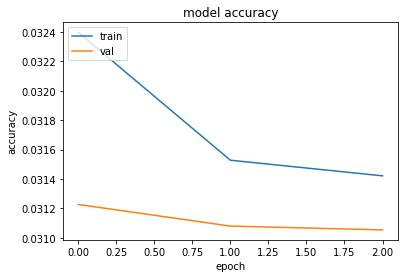

In [68]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
model.evaluate(X_test, y_test)

27327/27327 [==============================] - 8s 288us/step - loss: 0.0318 - binary_crossentropy: 0.0318


[0.03180576488375664, 0.03180576488375664]

In [56]:
model.save('./saved_model/ffnn_like')

INFO:tensorflow:Assets written to: ./saved_model/ffnn_like/assets


## Predict

In [57]:
model = tf.keras.models.load_model('./saved_model/ffnn_like')

In [69]:
pred = model.predict(X_test)

In [70]:
rce = compute_rce(pred, y_test)
rce

25.191294313062308

In [71]:
average_precision_score(y_test, pred)

0.14164184339984318